# Mall Customers - Aprendizaje No Supervisado - K Means - hierarchical clustering
En este ejercicio, nos enfocamos en el aprendizaje no supervisado utilizando técnicas como K Means y clustering jerárquico para analizar datos relacionados con clientes de un centro comercial. Nuestro objetivo es desarrollar un modelo que nos permita agrupar a los clientes según sus características principales, incluyendo su género, edad, ingreso anual y puntuación de gasto. La puntuación de gasto, en particular, representa una valoración asignada por el centro comercial basada en el comportamiento de compra y la naturaleza del gasto de cada cliente.

## Análisis Exploratorio de Datos (EDA)
En esta sección, llevaremos a cabo un análisis exploratorio de datos con el propósito de identificar valores nulos y atípicos, para abordarlos de manera adecuada. Además, nuestro objetivo es comprender a fondo nuestro conjunto de datos y explorar las posibles relaciones que puedan existir entre las variables.

### Librerías
A continuación, procedemos a cargar los conjuntos de datos que utilizaremos.

In [48]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Modelo K-means y hierarchical clustering
# ==============================================================================
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

#Configuración Gráficas
# ==============================================================================
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6, 4.5]
palette = ["#003049","#d62828","#f77f00","#fcbf49","purple", "green"]
sns.set_theme( palette= palette, context= "notebook")

#Tabular la salida
# ==============================================================================
from tabulate import tabulate

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Ingesta de Datos
En esta etapa, ingresamos los datos que emplearemos para el análisis, así como para la creación de los modelos de k-Means y clustering jerárquico.

In [49]:
# Cargamos los datos de entrada y los mostramos en pantalla para ver su estructura y contenido
# ==========================================================================================

df = pd.read_csv("Mall_Customers.csv", 
                 names= ["ID", 
                        "Genero", 
                        "Edad", 
                        "Ingresos", 
                        "Puntuacion_de_gasto"], 
                 header= 0)
df.head()

,ID,Genero,Edad,Ingresos,Puntuacion_de_gasto
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Resúmenes de Datos
En esta sección, llevamos a cabo resúmenes descriptivos del conjunto de datos para iniciar nuestra comprensión del mismo.

In [50]:
# Observamos la información acerca de los datos cargados
# ======================================================

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   200 non-null    int64 
 1   Genero               200 non-null    object
 2   Edad                 200 non-null    int64 
 3   Ingresos             200 non-null    int64 
 4   Puntuacion_de_gasto  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Como podemos observar, el conjunto de datos no contiene valores nulos, por lo que no es necesario realizar ningún tratamiento adicional para los datos faltantes.

### Transformación de Características
En esta etapa, vamos a analizar algunas variables y las posibles transformaciones en el conjunto de datos que podrían beneficiar su análisis posterior y la generación de los modelos no supervisados.

La columna **__ID__**, al tratarse de valores numéricos ordenados de manera ascendente con un incremento uniforme para todo el conjunto de datos, no proporciona información relevante que pueda ser utilizada en la creación de los modelos. Por lo tanto, podemos eliminarla del conjunto de datos.

In [51]:
# Eliminamos la columna ID que no aporta información relevante para el análisis de clustering
# ==========================================================================================

df.drop( columns= "ID", inplace= True)
df.head()

,Genero,Edad,Ingresos,Puntuacion_de_gasto
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### Valores Atípicos
En esta sección, generamos un diagrama de caja para visualizar la distribución de cada variable y detectar la presencia de valores atípicos o extremos.

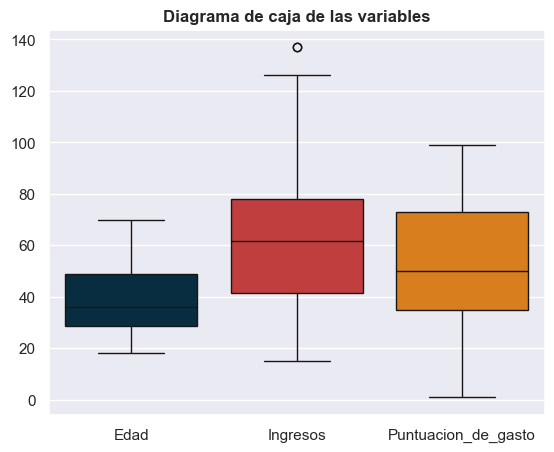

In [ ]:
# Creamos la gráficas de caja para visualizar la distribución de las variables
# ============================================================================

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 5))

sns.boxplot(data= df, ax= axes)

axes.set_title('Diagrama de caja de las variables', weight= "bold");

Aunque se identifica un valor atípico según el diagrama de cajas, al estar este dato cerca del rango establecido, esta observación se considera una medición legítima y no un error en los datos. Por lo tanto, decidimos mantenerla en nuestro conjunto de datos.

### Análisis Univariable
En esta sección, llevamos a cabo un análisis univariable de cada variable en nuestro conjunto de datos para comprender sus estadísticos descriptivos más relevantes y la distribución de cada una. Esto lo lograremos mediante la creación de histogramas de frecuencia.

In [53]:
# Calculamos los estadísticos descriptivos mas relevantes de las variables numéricas del dataset 
# =============================================================================================

df.describe(include= "number")

,Edad,Ingresos,Puntuacion_de_gasto
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [54]:
# Calculamos los estadísticos descriptivos mas importantes de las variables categóricas del dataset
# ================================================================================================
df.describe(include= "object")

,Genero
count,200
unique,2
top,Female
freq,112


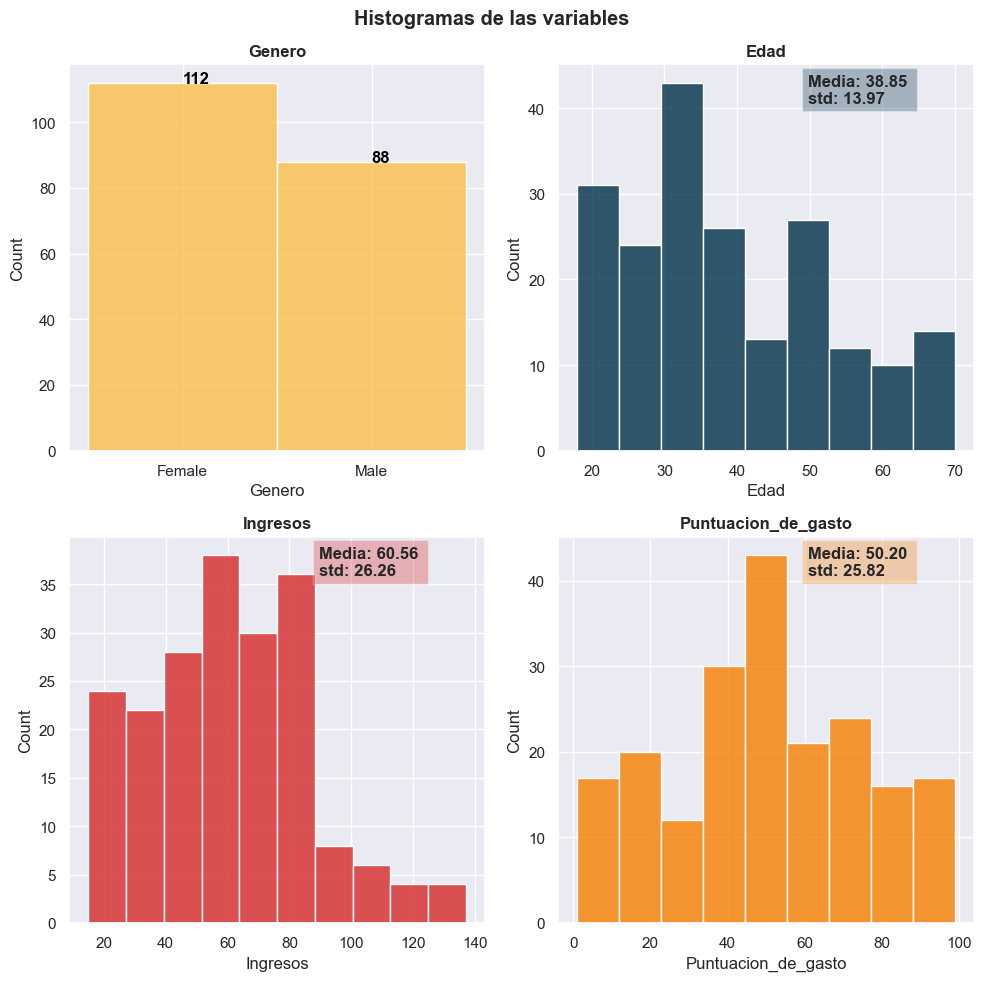

In [ ]:
# Creamos un gráfico de Distribución para las variables numéricas del dataset 
# ============================================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.histplot(data= df["Genero"].sort_values(), ax= axes[0, 0], discrete= True, color= palette[3], alpha= 0.8)
for i in range(2):
    axes[0, 0].text(x= i, y=df["Genero"].value_counts()[i] ,s= f"{df['Genero'].value_counts()[i]}", weight= "bold", color= "black")
axes[0, 0].set_title("Genero", weight= "bold")

num_cols = df.select_dtypes(include= "number").columns

for i, columna in enumerate(num_cols):
    row= (i+1)//2
    col= (i+1)%2
    sns.histplot(data=df[columna], ax= axes[row, col], color= palette[i], alpha= 0.8)
    axes[row, col].set_title(columna, weight= "bold")
    axes[row, col].text(0.6, 0.9,f"Media: {df[columna].mean():.2f} \nstd: {df[columna].std():.2f}", bbox=dict(facecolor= palette[i], alpha=0.3), transform=axes[row, col].transAxes, weight= "bold")
fig.suptitle('Histogramas de las variables', weight= "bold");
fig.tight_layout()


Del análisis univariable, observamos lo siguiente:
- Hay más mujeres que hombres en el conjunto de datos.
- La franja de edad más común entre los clientes se encuentra entre 30 y 35 años.
- La mayoría de los ingresos de los clientes se sitúan por debajo de 90.
- La distribución de la *puntuacion_de_gasto* muestra una ligera concentración de datos en el centro, en el rango de 40 a 60 puntos.


### Análisis Bivariado
En esta sección, realizaremos un análisis bivariado para explorar las relaciones entre la variable *Género* y las variables numéricas. Esto nos proporcionará una comprensión más profunda de la interacción entre las diversas variables en nuestro conjunto de datos.

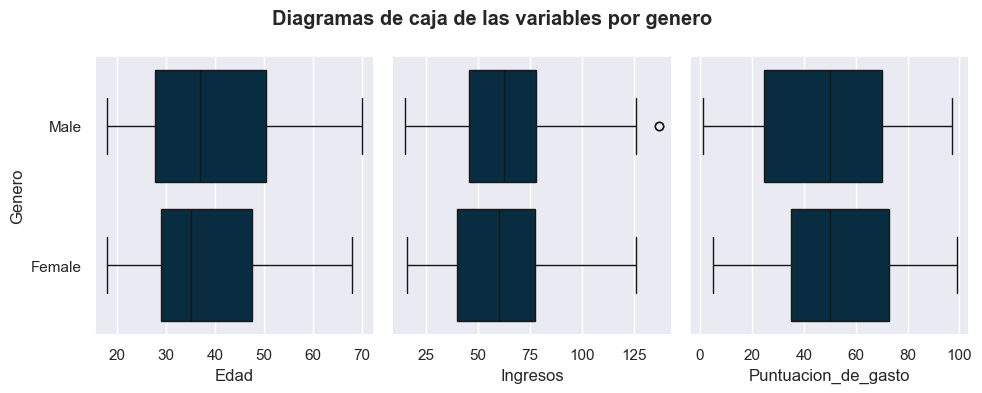

In [ ]:
# Realizamos un análisis Bivariado por medio de diagramas de caja para las variables numéricas del dataset 
# ==========================================================================================================

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4), sharey= True)

for i in range(3):
    sns.boxplot(x= df[num_cols[i]], ax= axes[i], y= df["Genero"])
    
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.suptitle('Diagramas de caja de las variables por genero', weight= "bold")

fig.tight_layout()


Del diagrama de cajas, podemos concluir que el género no introduce sesgos en ninguna distribución, lo que sugiere que esta variable no afecta a las demás.

### Analisis Multivariado
A continuación, exploraremos las relaciones entre las variables numéricas mediante diagramas de dispersión.

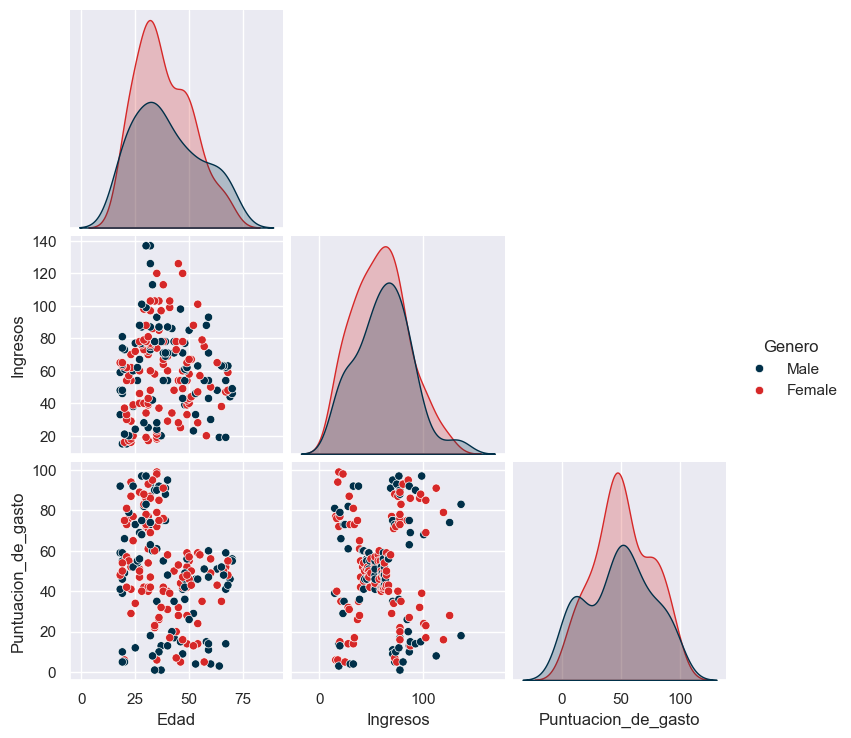

In [ ]:
# Generamos una matriz de gráficos de dispersion para las variables numéricas del dataset
# =======================================================================================

sns.pairplot(data= df, hue= "Genero", palette= palette, diag_kind= "kde", height= 2.5, corner= True);

Según los diagramas de dispersión, podemos observar que no existe ninguna relación evidente entre las variables numéricas de nuestro conjunto de datos

### Selección de Características
En este caso, se seleccionarán las variables *Edad*, *Ingresos* y *Puntuación de Gasto*, ya que se considera que el género puede no ser una característica relevante para el análisis que se está llevando a cabo. Además, su inclusión podría potencialmente conducir a la discriminación, ya sea de manera directa o indirecta, al segmentar a las personas en grupos basados en estereotipos de género.

In [58]:
# Eliminamos la columna Genero que no aporta información relevante para el análisis de clustering 
# ================================================================================================

df.drop(columns= "Genero", inplace= True)
df.head()

,Edad,Ingresos,Puntuacion_de_gasto
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


### Preprocesamiento de Características
A continuación, procederemos al preprocesamiento de las características utilizando StandarScaler(), con el fin de estandarizar todas las características en la misma escala y evitar sesgos generados por las diferencias de escala al crear los modelos no supervisados.

In [59]:
# Escalamos las variables numéricas del dataset para que tengan media 0 y desviación estándar 1 
# ============================================================================================

escaler = StandardScaler()
df_scaled = pd.DataFrame(escaler.fit_transform(df), columns= df.columns)
df_scaled.head()

,Edad,Ingresos,Puntuacion_de_gasto
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## Modelo De Machine Learning No supervisado - K-means
### Generación del Modelo
El modelo k-means es un algoritmo de agrupamiento o clustering utilizado en el análisis de datos y aprendizaje automático no supervisado. Su objetivo principal es dividir un conjunto de datos en grupos o clústeres basándose en características similares entre los datos. 

Como funciona K-Means: 

- El algoritmo trabaja iterativamente para asignar a cada punto uno de los k grupos según su similitud. Al ejecutar el algoritmo, obtenemos:

    - Los centroides de cada grupo consistirán en las coordenadas de cada uno de los k conjuntos que se utilizarán para etiquetar nuevas muestras.

    - Las etiquetas para el conjunto de datos de entrenamiento indicarán a qué grupo pertenece cada observación.

- Los grupos se van definiendo de manera “Orgánica”, es decir, que se va ajustando a su posición en cada iteración del proceso, hasta que converge el algoritmo. 

En esta etapa, procederemos a crear el modelo K-means utilizando diferentes números de clusters. Posteriormente, evaluaremos cuál es el número óptimo de clusters para nuestro modelo mediante el análisis del gráfico de codo.

In [60]:
# Creamos varios modelos de KMeans con un número de clusters de 1 a 10 y calculamos el score de cada modelo con el método score de KMeans
# ========================================================================================================================================

Nc = range(1, 11)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(df_scaled).score(df_scaled) for i in range(len(kmeans))]

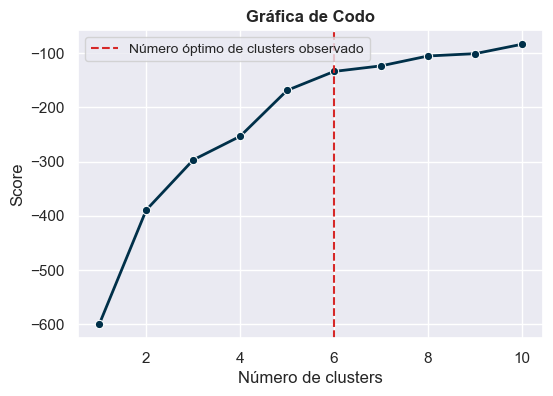

In [61]:
# Gráfica de Codo
# =====================================================================================

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.lineplot(ax= axes, x= Nc, y= score, color= palette[0], marker= "o", linewidth= 2)
axes.set_title('Gráfica de Codo', weight= "bold")
axes.set_xlabel('Número de clusters')
axes.set_ylabel('Score')
axes.axvline(x= 6, color= palette[1], linestyle= "--", label= "Número óptimo de clusters observado")
axes.legend(loc= "upper left", fontsize= "small");

Según el análisis del gráfico, el número óptimo de clusters observado es 6. Por lo tanto, procedemos a crear el modelo con 6 clusters definidos y lo entrenamos utilizando los datos escalados.

In [62]:
# Creamos el modelo
modelo_kmeans = KMeans(n_clusters= 6, random_state= 1234)

# Entrenamos el modelo
modelo_kmeans.fit(df_scaled)

# Obtenemos las etiquetas de los clusters
modelo_kmeans.labels_

array([5, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5,
       0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 4, 5, 0, 5,
       0, 5, 4, 3, 3, 3, 4, 5, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3,
       4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3,
       3, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 1, 3, 1, 2, 1, 2, 1, 2, 1,
       3, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 4, 1, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1])

### Evaluación del Modelo K-Means
Una vez generado el modelo K-Means, procedemos a evaluar su calidad de ajuste utilizando métricas como el Coeficiente de Silhouette, el Índice de Calinski-Harabasz, la Inercia y el Índice de Davies-Bouldin.

In [63]:
# Evaluamos el modelo con las métricas Calinski-Harabasz, Davies-Bouldin, Silhouette e inercia
# ============================================================================== 

table_metrics = [
    ["Número de clusters", modelo_kmeans.n_clusters],
    ["Calinski-Harabasz", calinski_harabasz_score(df_scaled, modelo_kmeans.labels_)],
    ["Davies-Bouldin", davies_bouldin_score(df_scaled, modelo_kmeans.labels_)],
    ["Silhouette", silhouette_score(df_scaled, modelo_kmeans.labels_)],
    ["Inercia", modelo_kmeans.inertia_]
]
print(tabulate(table_metrics, 
               headers=["Métrica", "Valor"], 
               tablefmt="fancy_grid", 
               stralign= "center", 
               numalign= "center")
    )

╒════════════════════╤══════════╕
│      Métrica       │  Valor   │
╞════════════════════╪══════════╡
│ Número de clusters │    6     │
├────────────────────┼──────────┤
│ Calinski-Harabasz  │ 134.475  │
├────────────────────┼──────────┤
│   Davies-Bouldin   │ 0.834966 │
├────────────────────┼──────────┤
│     Silhouette     │ 0.431065 │
├────────────────────┼──────────┤
│      Inercia       │ 134.353  │
╘════════════════════╧══════════╛


De las métricas de evaluación del modelo con 6 clusters, observamos lo siguiente:

- La métrica Calinski-Harabasz de 135.102 es relativamente alta, lo que sugiere una buena separación entre los clusters y una menor dispersión entre ellos.
- La métrica de Davies-Bouldin es de 0.827, indicando que los clusters están relativamente bien definidos y separados entre sí. Un valor más bajo indica una mejor separación entre los clusters.
- El coeficiente de Silhouette de 0.427, aunque está ligeramente alejado del valor ideal de 1, sugiere que los datos están relativamente bien asignados a los clusters, lo que indica una buena cohesión y separación entre ellos.
- La métrica de Inercia representa el valor total de la varianza dentro de todos los clusters. El valor obtenido de 133.868 sugiere que los clusters tienen una varianza relativamente baja entre ellos.

### Generación de Gráficas de los Resultados del Modelo
A continuación, crearemos representaciones gráficas que permitirán visualizar los resultados obtenidos por el modelo no supervisado K-means. Esto lo lograremos añadiendo las etiquetas de cluster al conjunto de datos y posteriormente representándolo mediante gráficos de dispersión, lo que nos permitirá identificar los clusters generados.

In [64]:
# Añadimos las etiquetas al conjunto de datos
# ==============================================

df["Cluster"] = modelo_kmeans.labels_
df.head()

,Edad,Ingresos,Puntuacion_de_gasto,Cluster
0,19,15,39,5
1,21,15,81,5
2,20,16,6,0
3,23,16,77,5
4,31,17,40,0


Calculamos los centroides de cada cluster, que son puntos centrales o valores medios de un cluster. En el algoritmo de Clustering K-Means, los centroides se utilizan para representar cada uno de los clusters.

In [65]:
# Calculamos la media de cada cluster para cada variable numérica y la desescalamos para interpretarla mejor
# =========================================================================================================================

centroides = modelo_kmeans.cluster_centers_
centroides = pd.DataFrame(data= escaler.inverse_transform(centroides), columns= ["Edad", "Ingresos", "Puntuacion_de_gasto"])
centroides

,Edad,Ingresos,Puntuacion_de_gasto
0,45.523810,26.285714,19.380952
1,32.692308,86.538462,82.128205
2,44.000000,90.133333,17.933333
3,26.125000,59.425000,44.450000
4,56.333333,54.266667,49.066667
5,25.560000,26.480000,76.240000


Ahora creamos gráficas de dispersión que relacionan cada una de las variables numéricas. Esto lo realizamos con el fin de observar los clusters generados del conjunto de datos. Además, también podemos graficar los centroides generados.

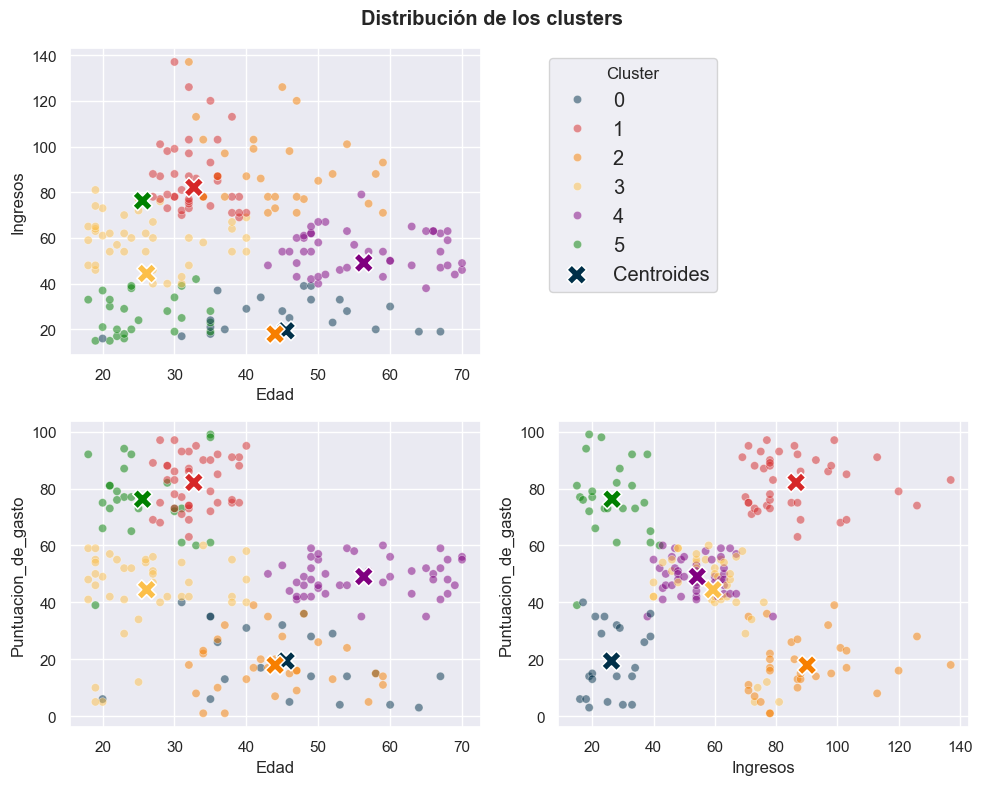

In [ ]:
# Generamos tres gráficas de Dispersion de forma que podamos ver cada cluster junto con su respectivo Centroide
# ===============================================================================================================

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Grafica de dispersión de Edad vs Ingresos
sns.scatterplot(data= df, x= "Edad", y= "Ingresos", hue= "Cluster", palette= palette, ax= axes[0, 0], alpha= 0.5)
sns.scatterplot(data= centroides, x= "Edad", y= "Puntuacion_de_gasto", hue= centroides.index , palette= palette, ax= axes[0,0], style= centroides.index, s= 200, markers= "X", label= "Centroides", legend= False)

# Grafica de dispersión de Edad vs Puntuacion_de_gasto
sns.scatterplot(data= df, x= "Edad", y= "Puntuacion_de_gasto", hue= "Cluster", palette= palette, ax= axes[1, 0], legend= False, alpha= 0.5)
sns.scatterplot(data= centroides, x= "Edad", y= "Puntuacion_de_gasto", hue= centroides.index , palette= palette, ax= axes[1,0], style= centroides.index, s= 200, markers= "X", legend= False)

# Grafica de dispersión de Ingresos vs Puntuacion_de_gasto
sns.scatterplot(data= df, x= "Ingresos", y= "Puntuacion_de_gasto", hue= "Cluster", palette= palette, ax= axes[1, 1], alpha=0.5, legend= False)
sns.scatterplot(data= centroides, x= "Ingresos", y= "Puntuacion_de_gasto", hue= centroides.index , palette= palette, ax= axes[1,1], style= centroides.index, s= 200, markers= "X", legend= False)

# Añadimos las etiquetas
fig.suptitle('Distribución de los clusters', weight= "bold")
fig.delaxes(axes[0, 1])

fig.tight_layout()

# Colocamos las etiquetas de los clusters en la leyenda
axes[0, 0].legend(loc= "upper right", title= "Cluster", bbox_to_anchor=(1.6, 1), fontsize= "larger");

Podemos generar un gráfico en 3D ya que estamos utilizando 3 variables, de esta forma podremos observar cómo se encuentran agrupadas en un espacio tridimensional.

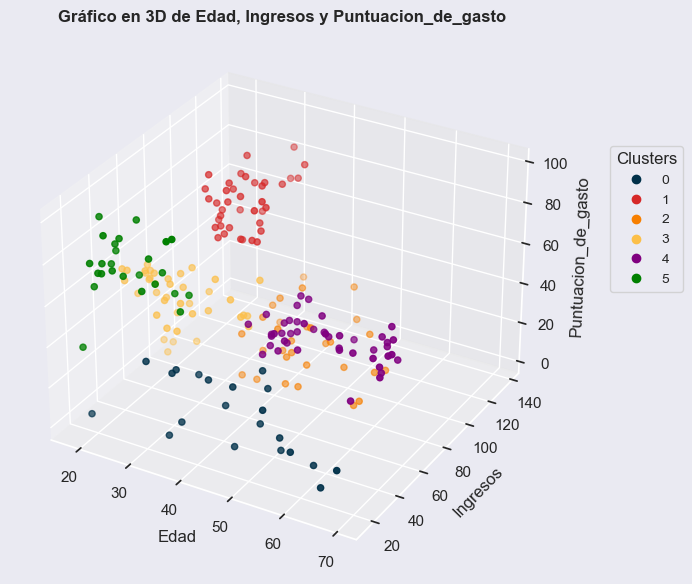

In [ ]:
# Creamos un gráfico en 3D para visualizar los clusters en función de las tres variables numéricas del conjunto de datos original 
# ================================================================================================================================

fig = plt.figure(figsize=(8, 6), facecolor= "#eaeaf2")
ax = fig.add_subplot(111, projection='3d', facecolor= "#eaeaf2")

colores = ListedColormap(palette)

# Creamos el gráfico en 3D
scatter= ax.scatter3D(df['Edad'], df['Ingresos'], df['Puntuacion_de_gasto'], c=df['Cluster'], cmap=colores)

# Configurar etiquetas y título
ax.set_xlabel('Edad')
ax.set_ylabel('Ingresos')
ax.set_zlabel('Puntuacion_de_gasto')
ax.set_title('Gráfico en 3D de Edad, Ingresos y Puntuacion_de_gasto', weight= "bold")

# Crear leyenda a partir de los colores únicos en los datos
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right", bbox_to_anchor=(1.25, 0.8), fontsize= "small")

fig.tight_layout()

Como podemos observar, de acuerdo a los gráficos de dispersión generados, podemos concluir:

- Cuando realizamos la comparación entre dos variables, se pueden observar que los diferentes clusters se encuentran relativamente separados.
- En el gráfico de dispersión entre *ingresos* y *edad*, podemos observar que todos los clusters se encunetran bien definidos, a excepción del cluster 0 que se encuentran mezclados junto con los demás.
- En el gráfico entre *puntuacion de gasto* y *edad*, podemos observar de una mejor forma cada uno de los clusters; sin embargo, hay algunos datos que se superponen, lo que provoca que algunos clusters se mezclen.
- En el gráfico de *puntuacion de gasto* e *ingresos*, se pueden ver bien definidos los clusters; sin embargo, los clusters 1 y 2 se encuentran mezclados.
- El gráfico 3D nos permite observar mejor los diferentes clusters y la distancia que hay entre ellos.

## Modelo de Aprendizaje Automático No Supervisado - Clustering Jerárquico
### Generación del Modelo
 Este un enfoque de agrupación jerárquica que se basa en la determinación de agrupaciones sucesivas a partir de agrupaciones previamente definidas. Es una técnica destinada a agrupar datos en un árbol de agrupados llamados Dendrogramas, que representa gráficamente la relación jerárquica entre los grupos subyacentes. 

El agrupamiento se inicia con todas las observaciones separadas, cada una formando un clúster individual. *(Clustering con Python - Ciencia de datos, 2020)*. Los clústeres se van combinando a medida que la estructura crece hasta converger en uno solo. 

En esta etapa, procederemos a crear el modelo de Clustering Jerárquico. Para determinar el número óptimo de clusters, utilizaremos un dendrograma que nos permitirá observar la distancia máxima en la cual podemos realizar el corte para obtener el número de clusters.

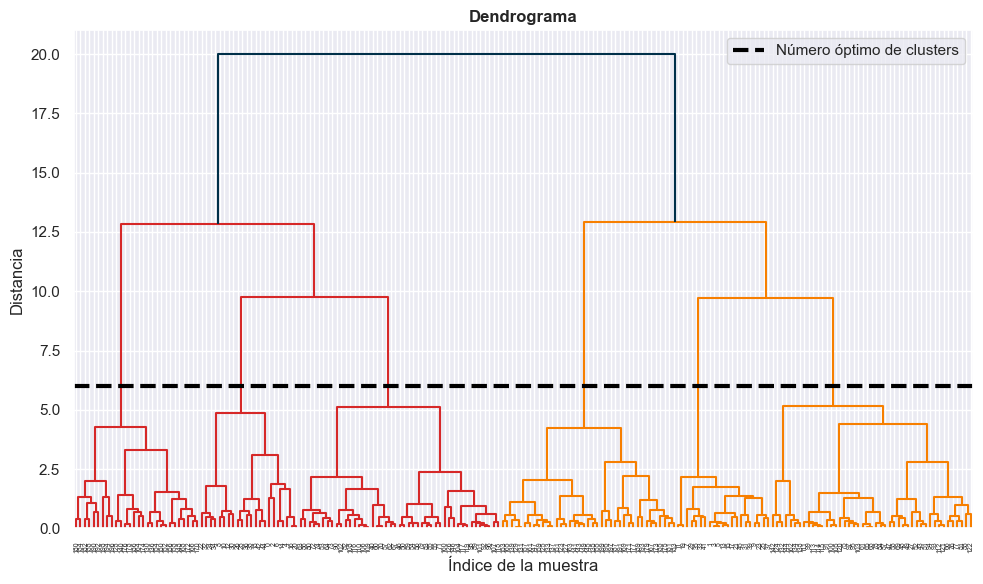

In [68]:
# Creamos un dendrograma para visualizar la jerarquía de los clusters en función de la distancia entre ellos
# =============================================================================================================

ward_link = linkage(df_scaled, method= "ward", metric= "euclidean")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Creamos el dendrograma con la función dendrogram de scipy y lo mostramos
dendrogram(ward_link, ax= axes)
axes.set_title('Dendrograma', weight= "bold")
axes.set_xlabel('Índice de la muestra')
axes.set_ylabel('Distancia')

# Colocamos el punto de corte en la distancia óptima para obtener el número de clusters
axes.axhline(y= 6, color= "black", linestyle= "--", linewidth= 3, label= "Número óptimo de clusters")
axes.legend()

fig.tight_layout()

Como podemos observar, el punto óptimo de clusters marcado por la línea de corte indica 6 clusters. Además, podemos utilizar el método Silhouette para determinar el valor óptimo de clusters a utilizar en el modelo. El número óptimo de clusters será aquel que tenga una puntuación Silhouette más cercana a 1.

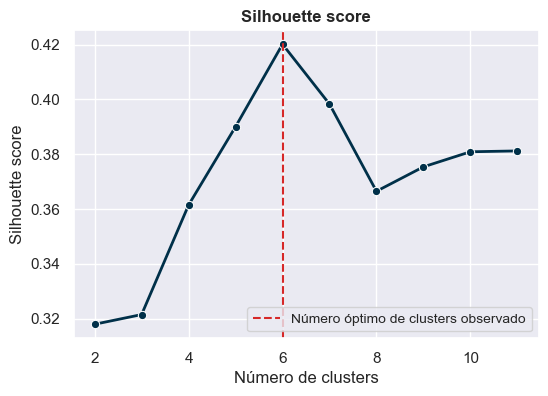

In [69]:
# Definimos un rango de clusters del 2 al 11
rango_clusters = range(2, 12)

# Creamos una lista vacía para almacenar los valores de Silhouette score
silhouette_scores = []

# Iteramos sobre cada número de clusters en el rango definido
for n_clusters in rango_clusters:
    
    modelo_hierarchical = AgglomerativeClustering(n_clusters= n_clusters, linkage= "ward")
    modelo_hierarchical.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, modelo_hierarchical.labels_))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.lineplot(ax= axes, x= rango_clusters, y= silhouette_scores, color= palette[0], marker= "o", linewidth= 2)
axes.set_title('Silhouette score', weight= "bold")
axes.set_xlabel('Número de clusters')
axes.set_ylabel('Silhouette score')

# Trazamos  una línea vertical en el número óptimo de clusters observado
axes.axvline(x= 6, color= palette[1], linestyle= "--", label= "Número óptimo de clusters observado")

# Agregamos una leyenda al gráfico
axes.legend(fontsize= "small");


En ambos métodos utilizados se indica que el número óptimo de clusters será de 6. Ahora que tenemos esta información, procederemos a crear los grupos utilizando el método aglomerante, asignando a cada observación el grupo al que pertenece.

In [70]:
# Creamos el modelo con el número óptimo de clusters observado y ajustamos el modelo a los datos escalados 
# =============================================================================================================

modelo_hierarchical = AgglomerativeClustering(n_clusters= 6, linkage= "ward")
modelo_hierarchical.fit(df_scaled)

# Añadimos las etiquetas al conjunto de datos
df["Cluster_hierarchical"] = modelo_hierarchical.labels_

Generamos gráficas de dispersión que nos permiten identificar cada cluster generado por el método Hierarchical Clustering en relación a las tres variables con las que alimentamos el modelo.

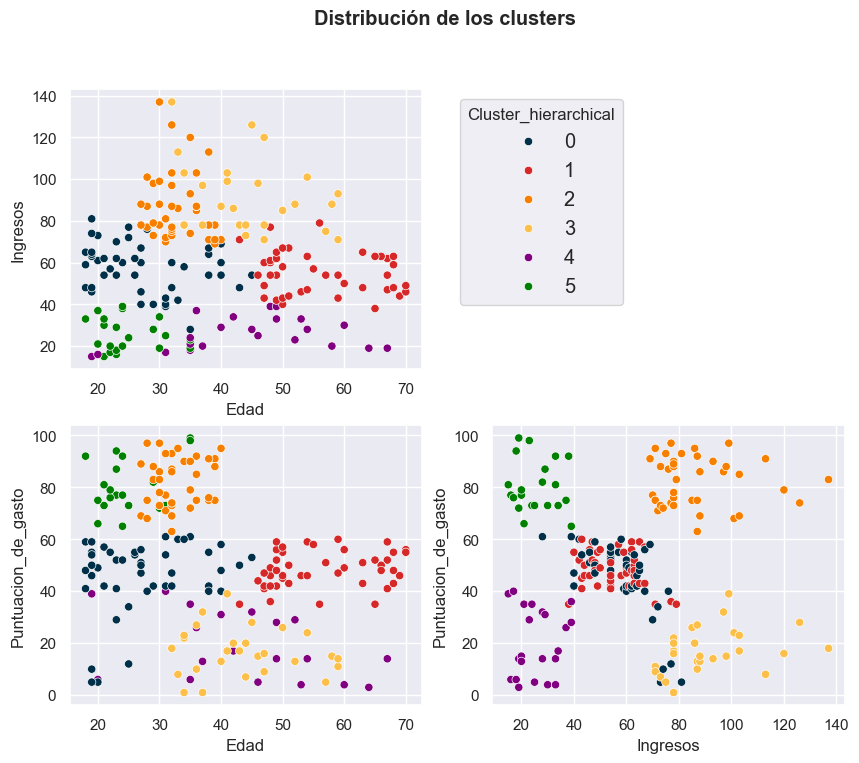

In [ ]:
# Creamos las Gráficas de dispersión para visualizar los clusters en función de las tres variables numéricas del conjunto de datos original
# ================================================================================================================================

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.scatterplot(data= df, x= "Edad", y= "Ingresos", hue= "Cluster_hierarchical", palette= palette, ax= axes[0, 0])
sns.scatterplot(data= df, x= "Edad", y= "Puntuacion_de_gasto", hue= "Cluster_hierarchical", palette= palette, ax= axes[1, 0], legend= False)
sns.scatterplot(data= df, x= "Ingresos", y= "Puntuacion_de_gasto", hue= "Cluster_hierarchical", palette= palette, ax= axes[1, 1], legend= False)

fig.delaxes(axes[0, 1])
axes[0, 0].legend(loc= "upper right", title= "Cluster_hierarchical", bbox_to_anchor=(1.6, 1), fontsize= "larger")
fig.suptitle('Distribución de los clusters', weight= "bold");


Generamos el gráfico 3D que nos permite observar los clusters generados por el método Hierarchical Clustering.

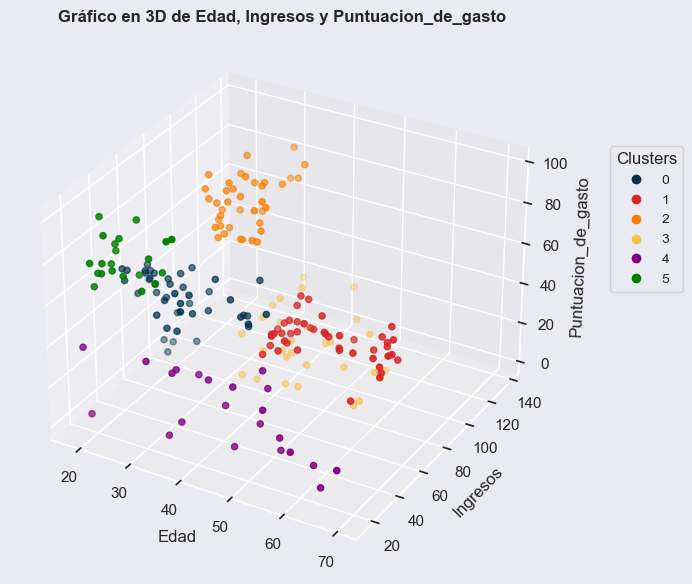

In [ ]:

# Creamos un gráfico en 3D para visualizar los clusters en función de las tres variables numéricas del conjunto de datos original 
# ================================================================================================================================

fig = plt.figure(figsize=(8, 6), facecolor= "#eaeaf2")
ax = fig.add_subplot(111, projection='3d', facecolor= "#eaeaf2")

colores = ListedColormap(palette)

# Creamos el gráfico en 3D
scatter= ax.scatter3D(df['Edad'], df['Ingresos'], df['Puntuacion_de_gasto'], c=df['Cluster_hierarchical'], cmap=colores)

# Configurar etiquetas y título
ax.set_xlabel('Edad')
ax.set_ylabel('Ingresos')
ax.set_zlabel('Puntuacion_de_gasto')
ax.set_title('Gráfico en 3D de Edad, Ingresos y Puntuacion_de_gasto', weight= "bold")

# Crear leyenda a partir de los colores únicos en los datos
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right", bbox_to_anchor=(1.25, 0.8), fontsize= "small")

fig.tight_layout()

## Evaluación del Modelo Hierarchical Clustering
A continuación, vamos a realizar la evaluación del modelo a través de sus principales métricas de evaluación de la bondad del modelo, como el Índice de Calinski-Harabasz, el Índice de Davies-Bouldin y el Coeficiente de Silhouette. Para esto, utilizaremos el módulo *sklearn.metrics*.

In [ ]:
# Creamos una tabla con las métricas de evaluación del modelo de clustering jerárquico
# =====================================================================================

table_metrics = [
    ["Número de clusters", modelo_hierarchical.n_clusters],
    ["Calinski-Harabasz", calinski_harabasz_score(df_scaled, modelo_hierarchical.labels_)],
    ["Davies-Bouldin", davies_bouldin_score(df_scaled, modelo_hierarchical.labels_)],
    ["Silhouette", silhouette_score(df_scaled, modelo_hierarchical.labels_)],
]
print(tabulate(table_metrics, 
               headers=["Métrica", "Valor"], 
               tablefmt="fancy_grid", 
               stralign= "center", 
               numalign= "center"))

╒════════════════════╤══════════╕
│      Métrica       │  Valor   │
╞════════════════════╪══════════╡
│ Número de clusters │    6     │
├────────────────────┼──────────┤
│ Calinski-Harabasz  │ 127.986  │
├────────────────────┼──────────┤
│   Davies-Bouldin   │ 0.852102 │
├────────────────────┼──────────┤
│     Silhouette     │ 0.420117 │
╘════════════════════╧══════════╛


Del modelo de agrupación creado mediante el método de Clustering Jerárquico, podemos observar lo siguiente:

- El valor óptimo de clusters coincide con el mismo número de clusters óptimo observado en el método K-means, que es de 6 clusters.
- El valor obtenido de Calinski-Harabasz es de 127.986, ligeramente más bajo que el valor obtenido con K-means, pero aún sugiere una buena separación entre los clusters.
- El valor de Davies-Bouldin obtenido con este método es de 0.852102, ligeramente más alto que el valor obtenido con K-means, pero aún sugiere que los clusters están relativamente bien definidos y separados entre sí.
- El coeficiente de Silhouette, que cuantifica qué tan similar es un objeto a su propio cluster en comparación con otros clusters, obtuvo un valor de 0.420117. Aunque es un poco más bajo que el valor obtenido con K-means, aún sugiere que los datos están relativamente bien asignados a los clusters, lo que indica una buena cohesión y separación entre ellos.

Además, podemos calcular el coeficiente de cophenet, que es una medida de la correlación entre las distancias originales de los datos y las distancias obtenidas en el dendrograma generado por el algoritmo de agrupación jerárquica. Este coeficiente nos ayuda a evaluar qué tan bien el dendrograma preserva las distancias originales entre los puntos de datos. 

In [74]:
# Calculamos la matriz de distancias y el coeficiente de cophenet
# =============================================================

X_dist = pdist(df_scaled, metric= "euclidean")
cophenet(ward_link, X_dist)
print(f" El coeficiente de cophenet es: {cophenet(ward_link, X_dist)[0]:.3f}")

 El coeficiente de cophenet es: 0.626


Un coeficiente de cophenet cercano a 1 indica que las distancias entre los puntos en el dendrograma son consistentes con las distancias originales entre los puntos de datos. Por lo tanto, un valor de 0.63 sugiere que el dendrograma captura moderadamente bien las relaciones de distancia entre los puntos originales, aunque puede haber cierta discrepancia entre las distancias originales y las representadas en el dendrograma.

## Referencias Bibliográficas
 - Berzal, F. (2017). Clustering jerárquico. Universidad de Granada,[En línea]. https://elvex.ugr.es/idbis/dm/slides/42%20Clustering.

 - Carlos Véliz. (2020). Aprendizaje automático. Introducción al aprendizaje profundo. El Fondo Editorial de la Pontificia Universidad Católica del Perú.

 - Clustering con Python - Ciencia de datos. https://cienciadedatos.net/documentos/py20-clustering-con-python.html.

 - Giuseppe Bonaccorso. (2018). Machine Learning Algorithms : Popular Algorithms for Data Science and Machine Learning, 2nd Edition: Vol. 2nd ed. Packt Publishing.

 - Minguillón, J. Casas, J. y Minguillón, J. (2017). Minería de datos: modelos y algoritmos. Editorial UOC.
 
 - Pratap Dangeti. (2017). Statistics for Machine Learning : Build Supervised, Unsupervised, and Reinforcement Learning Models Using Both Python and R. Packt Publishing.





